In [1]:
!pip install nam>=0.0.3

In [2]:

from abc import ABC, abstractmethod


class Explainer(ABC):

    def __init__(self):
        pass

    @abstractmethod
    def fit(self, X, y):
        pass

    @abstractmethod
    def explain(self, x):
        pass

    @abstractmethod
    def predict(self, x):
        pass

    @abstractmethod
    def predict_proba(self, x):
        pass


class Explanation(ABC):

    def __init__(self):
        pass

    @abstractmethod
    def getFeaturesImportance(self):
        pass

    @abstractmethod
    def getExemplars(self):
        pass

    @abstractmethod
    def getCounterExemplars(self):
        pass

    @abstractmethod
    def getRules(self):
        pass

    @abstractmethod
    def getCounterfactualRules(self):
        pass


from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams
from nam.config import defaults
from nam.data import FoldedDataset, NAMDataset
from nam.models import NAM, get_num_units
from nam.trainer import LitNAM
from nam.utils import *
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from nam.trainer import Trainer



class NamExplanation(Explanation):
    def __init__(self, exp, feature_names: list, bias: float):
        super().__init__()
        self.exp = exp
        self.feature_names = feature_names
        self.bias = bias

    def getFeaturesImportance(self):
        return self.exp

    def getExemplars(self):
            return None

    def getCounterExemplars(self):
        return None

    def getRules(self):
        return None

    def getCounterfactualRules(self):
        return None


from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams
from nam.config import defaults
from nam.data import FoldedDataset, NAMDataset
from nam.models import NAM, get_num_units
from nam.trainer import LitNAM
from nam.utils import *
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from nam.trainer import Trainer



class NamExplanation(Explanation):
    def __init__(self, exp, feature_names: list, bias: float):
        super().__init__()
        self.exp = exp
        self.feature_names = feature_names
        self.bias = bias

    def getFeaturesImportance(self):
        return self.exp

    def getExemplars(self):
            return None

    def getCounterExemplars(self):
        return None

    def getRules(self):
        return None

    def getCounterfactualRules(self):
        return None



class NamTransparentByDesign(Explainer):

    def __init__(self, X, y, feature_names, target_name, config=None, **kwargs):
        """
            NAM: Neural Additive Models - Interpretable Machine Learning with Neural Nets

        @param X: Input features
        @param y: values to predict
        @param feature_names: names of input features
        @param target_name: name of the target feature
        @param config: [opt] config object to use instead of default
        @param kwargs: parameters to alter in the default config
        """
        config = defaults() if (config is None) else config
        self.config = config
        config.update(**kwargs)
        print(config)
        self.feature_names = feature_names
        self.target_name = target_name
        df = pd.DataFrame(X, columns=feature_names)
        df[target_name] = y
        dataset = NAMDataset(config, data_path=df, features_columns=feature_names,
                             targets_column=target_name)
        self.dataset = dataset
        self.model = NAM(
            config=config,
            name="NAM_SIM",
            num_inputs=len(dataset[0][0]),
            num_units=get_num_units(config, dataset.features),
        )

    def fit(self, dataloaders=None):
        config = self.config
        model = self.model
        tb_logger = TensorBoardLogger(config.logdir, name=f'{model.name}')
        checkpoint_callback = ModelCheckpoint(filename=tb_logger.log_dir +
                                                       "/{epoch:02d}-{val_loss:.4f}",
                                              monitor='val_loss',
                                              save_top_k=config.save_top_k,
                                              mode='min')

        if dataloaders is None:
            dataloaders = self.dataset.train_dataloaders()
        for fold, (train_dl, valid_dl) in enumerate(dataloaders):
            litmodel = LitNAM(config, model)
            trainer = pl.Trainer(logger=tb_logger,
                                 max_epochs=config.num_epochs, )
            trainer.fit(litmodel,
                        train_dataloaders=train_dl,
                        val_dataloaders=valid_dl)
        self.trainer = trainer
        self.bias = self.model._bias
        self.model.eval()

    def explain(self, x):
        pred, fnn_out = self.predict(x, return_fnn_out=True)
        return NamExplanation(fnn_out, self.feature_names, self.bias)

    def predict(self, x: torch.tensor, return_fnn_out=False):
        pred, fnn_out = self.model(x)
        if return_fnn_out:
            return pred, fnn_out
        return pred

    def test(self):
        self.trainer.test(test_dataloaders=self.dataset.test_dataloaders())
        self.model.eval()

    def predict_proba(self, x: torch.tensor):
        pred, fnn_out = self.model(x)
        return pred

    def explain_global(self, num_cols=2):
        plot_mean_feature_importance(self.model, self.dataset)
        plot_nams(self.model, self.dataset, num_cols=num_cols)







# Init NAMs with defaults values
[NAMs github repo](https://github.com/AmrMKayid/nam)

## NAMs automatic train, valid, test split

Synthetic dataset

In [3]:
import csv
import numpy as np
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

np.random.seed(0)

bs = 2  #This is the square root of the number of betas. Square root for plotting convenience
obs = 10000  #Number of obs
const = 5  #Constant a in y=a+beta*x+e
badd = 1  #Multiplies the normally distributed random betas by a constant
eadd = 1.7

#Creating the real underlying data
X = np.random.normal(size=[obs, bs**2])
errors = eadd * np.random.normal(size=[obs])
beta = badd * np.random.normal(size=[bs**2])
y = (const + np.matmul(np.sin(5 * X), beta) + errors)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# additional_custom_config_params = dict(regression=False, seed=42) # see git repo for more
# model = NamTransparentByDesign(X, y, iris.feature_names, 'specie', **additional_custom_config_params)
model = NamTransparentByDesign(X=X, y=y, feature_names=["x1", "x2", "x3", "x4"], target_name='y')

Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.5, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.5, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.5, logdir='output', lr=0.0003, num_basis_functions=1000, num_epochs=1, num_folds=5, num_models=1, num_splits=3, num_workers=16, optimizer='adam', output_regularization=0.5, regression=False, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=True)


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


In [5]:
model.fit()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 272 K 
-------------------------------
272 K     Trainable params
0         Non-trainable params
272 K     Total params
1.090     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [6]:
model.test()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:907: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1399: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at output/NAM_SIM/version_17/checkpoints/epoch=0-step=7.ckpt
Loaded model weights from checkpoint at output/NAM_SIM/version_17/checkpoints/epoch=0-step=7.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 1.0,
 'Accuracy_metric_epoch': 1.0,
 'test_loss': -19519.2265625,
 'test_loss_epoch': -19519.2265625}
--------------------------------------------------------------------------------


In [7]:

item = torch.tensor([[-2.55298982,  0.6536186 ,  0.8644362 , -0.74216502],[ 7.45472240e-01,  3.47939136e-01, -2.59534011e-01,
    -4.23024293e-04], [-1.55298982,  0.2336186 ,  0.5544362 , -0.74216502]])
pred = model.predict(item)
display(pred)

tensor([4.7820, 3.5819, 4.7470], grad_fn=<AddBackward0>)

### Local features importance

In [8]:
exp = model.explain(item)
exp.getFeaturesImportance()

tensor([[1.1477, 1.1808, 1.6245, 0.8266],
        [1.1477, 1.1468, 0.4583, 0.8266],
        [1.1477, 1.1469, 1.6234, 0.8266]], grad_fn=<CatBackward0>)

In [9]:
exp.getFeaturesImportance().sum(1) 

tensor([4.7796, 3.5795, 4.7446], grad_fn=<SumBackward1>)

In [10]:
exp.getFeaturesImportance().sum(1) + exp.bias == pred

tensor([True, True, True])

### Additional global explanation with shape functions

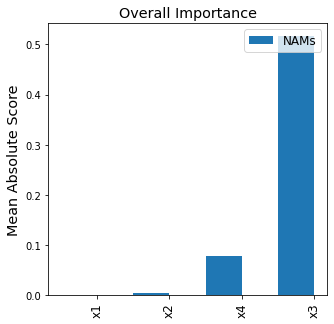

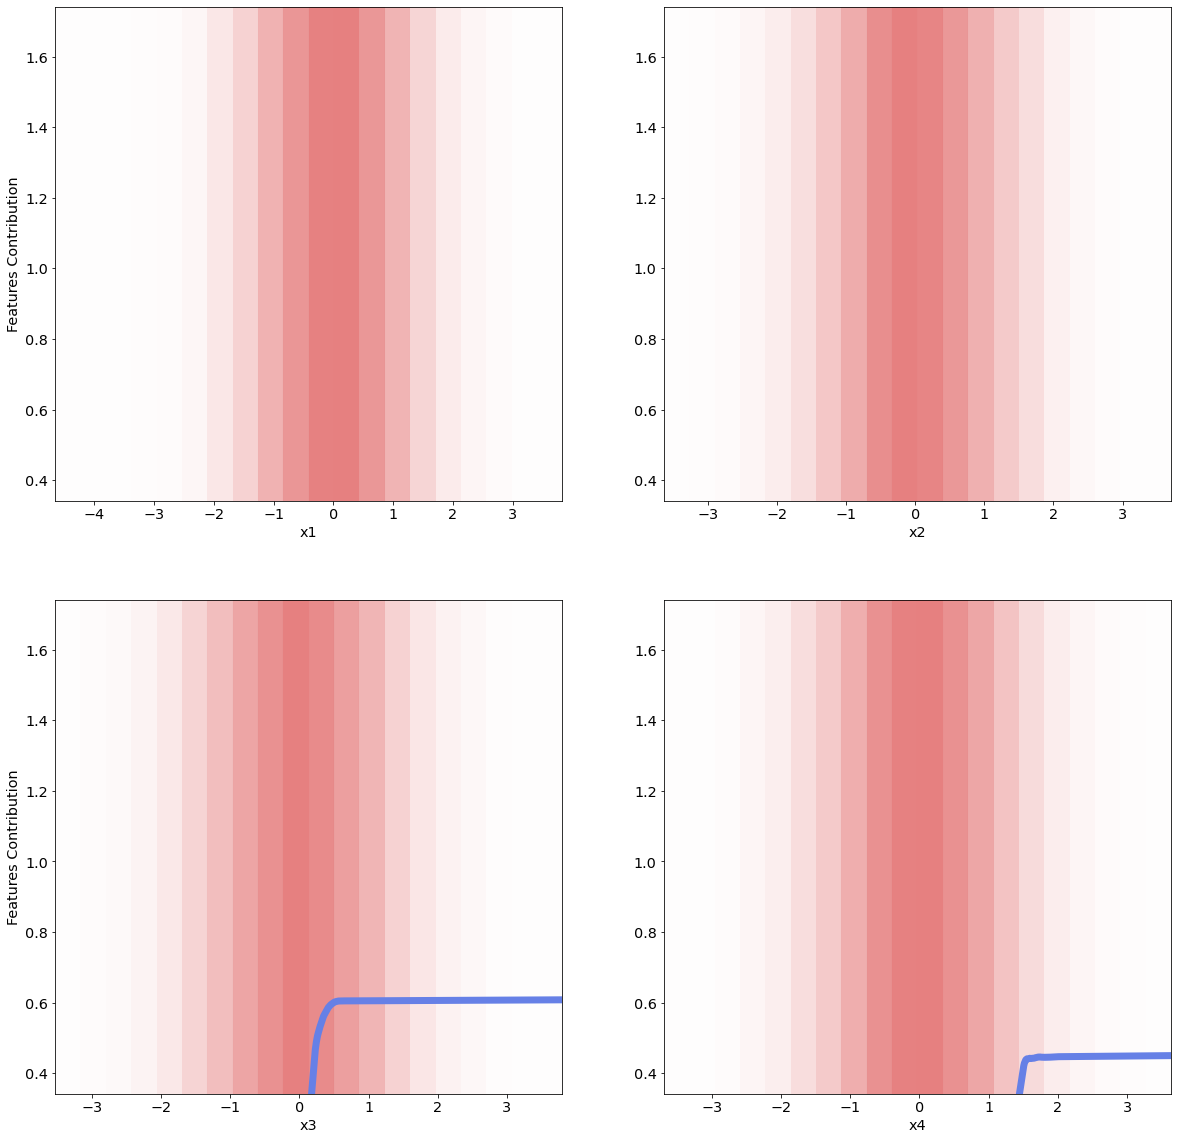

In [11]:
model.explain_global()

## Manual train, valid, test split

In [12]:
from nam.data import load_gallup_data, load_housing_data, load_sklearn_housing_data, load_breast_data
from nam.config import defaults
config = defaults()
nam_dataset = load_sklearn_housing_data(config)

In [13]:
X = nam_dataset.features
y = nam_dataset.targets

In [14]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item: int):
        return self.X[item], self.y[item]

In [15]:
dataset = MyDataset(X,y)

In [16]:
from torch.utils.data import random_split
batch_size = 1024

val_split, test_split = 0.1, 0.2

test_size = int(test_split * len(X))
val_size = int(val_split * (len(X) - test_size))
train_size = len(X) - val_size - test_size

train_subset, val_subset, test_subset = random_split(dataset, [train_size, val_size, test_size])

train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

val_dl = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

test_dl = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [17]:
model = NamTransparentByDesign(X=nam_dataset.features.numpy(), y=nam_dataset.targets, feature_names=nam_dataset.features_names, target_name=nam_dataset.targets_column)

Config(activation='exu', batch_size=1024, cross_val=False, data_path='data/GALLUP.csv', decay_rate=0.995, device='cpu', dropout=0.5, early_stopping_patience=50, experiment_name='NAM', feature_dropout=0.5, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.5, logdir='output', lr=0.0003, num_basis_functions=1000, num_epochs=1, num_folds=5, num_models=1, num_splits=3, num_workers=16, optimizer='adam', output_regularization=0.5, regression=False, save_model_frequency=2, save_top_k=3, seed=2021, shuffle=True, units_multiplier=2, use_dnn=False, wandb=True)


/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:172: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


In [18]:
train_dataloaders = [(train_dl, val_dl)]

In [19]:
model.fit(train_dataloaders)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 486 K 
-------------------------------
486 K     Trainable params
0         Non-trainable params
486 K     Total params
1.944     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [20]:
item = torch.tensor([[ 0.0761, -0.2157, -0.9236, -0.9621, -0.8656, -0.9977,  0.1307, -0.5757],
        [-0.0679,  1.0000, -0.8945, -0.9561, -0.9724, -0.9966,  0.1286, -0.5797],
        [-0.2906,  1.0000, -0.9295, -0.9561, -0.9689, -0.9970,  0.1286, -0.5817]])
pred = model.predict(item)
display(pred)

exp = model.explain(item)
display(exp.getFeaturesImportance())

exp.getFeaturesImportance().sum(1) + exp.bias == pred

tensor([1.9971, 1.7435, 1.7435], grad_fn=<AddBackward0>)

tensor([[0.3265, 0.3053, 0.2126, 0.2626, 0.2641, 0.2255, 0.1395, 0.2565],
        [0.3265, 0.0517, 0.2126, 0.2626, 0.2641, 0.2255, 0.1395, 0.2565],
        [0.3265, 0.0517, 0.2126, 0.2626, 0.2641, 0.2255, 0.1395, 0.2565]],
       grad_fn=<CatBackward0>)

tensor([True, True, True])

In [21]:
nam_dataset.features_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

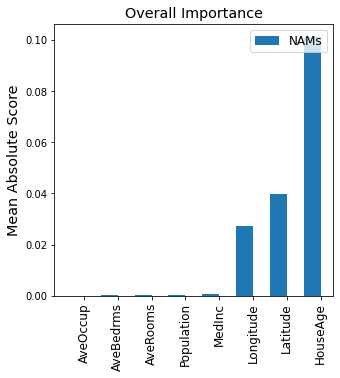

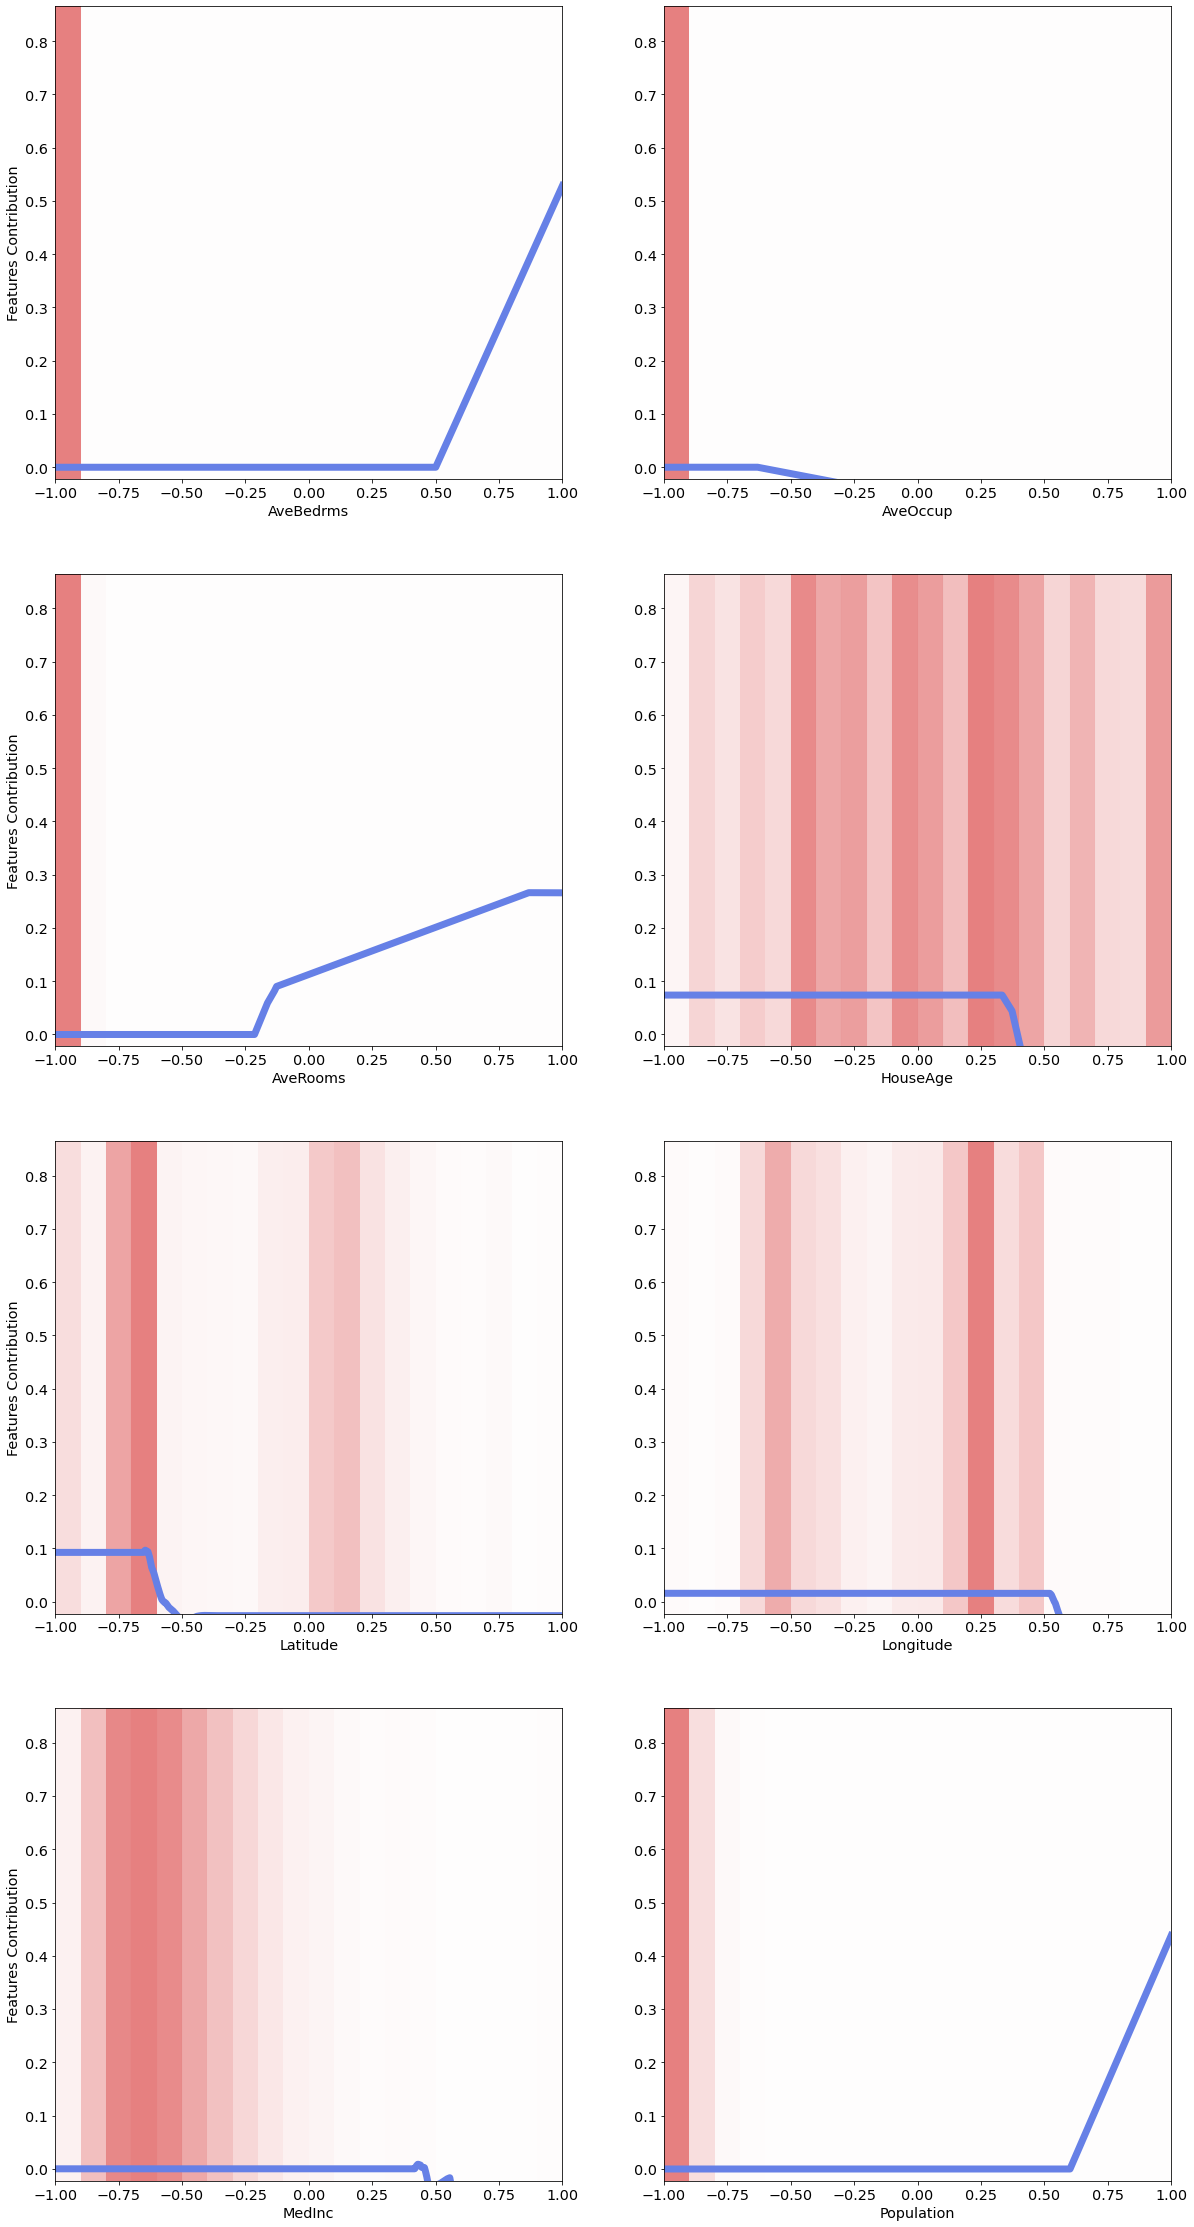

In [22]:
model.explain_global()